# Simulation code of System\#1

<img src="FigureFolder/System1.png" width="400">

A structurally simple radial power network is considered, where $n$ generators jointly supply power to a single large load. Therefore, a failure on a transmission line may directly result in load loss, making it possible to highlight the effects of different approaches to handling probabilities.

This notebook conducts simulations based on the physical mechanism of <font color='red'>damage caused only by instantaneous intensity</font>.

With Python and Jupyter Notebook properly configured, you can directly run this notebook from start to finish.

In [1]:
from Utils.Pyd.MonteCarlo_Utils import MonteCarlo_Naive_Sample, MonteCarlo_XULUO_Sample, \
    MonteCarlo_Past_Info_Sample, \
    MonteCarlo_Fatigue_Accumulation_Sample
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from scipy.stats import norm
from scipy.interpolate import UnivariateSpline
import pickle

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["mathtext.default"] = "rm"

np.random.seed(613)
random.seed(613)

deltaT_name_list = {
    3 / 3600: r'$\Delta \it{t}=3\ \mathrm{s}$',
    1 / 120:  r'$\Delta \it{t}=30\ \mathrm{s}$',
    1 / 60: r'$\Delta \it{t}=1\ \mathrm{min}$',
    1 / 12: r'$\Delta \it{t}=5\ \mathrm{min}$',
    0.1: r'$\Delta \it{t}=0.1\ \mathrm{h}$',
    0.2: r'$\Delta \it{t}=0.2\ \mathrm{h}$',
    0.25: r'$\Delta \it{t}=15\ \mathrm{min}$',
    0.5: r'$\Delta \it{t}=0.5\ \mathrm{h}$',
    1: r'$\Delta \it{t}=1\ \mathrm{h}$',
    2: r'$\Delta \it{t}=2\ \mathrm{h}$',
    3: r'$\Delta \it{t}=3\ \mathrm{h}$'
}

In [2]:
# Parameter Setting
n = 10              # Number of generators/transmission lines
T = 48              # Total simulation time (in hours)
BASE_DELTAT = 3 / 3600  # 3 sec, Finest base time step (in hours)
deltaT_list = [BASE_DELTAT, 1 / 120 , 1 / 60, 1 / 12, 0.25, 1, 2, 3] # List of time steps to study
N_sim = 100         # Number of Monte Carlo simulations
P_gen = 10          # Maximum power of each generator (MW)

In [3]:
t = np.arange(0, T, BASE_DELTAT)

In [4]:
# Generate Load Demand Curve: Simulating Daily Load Variation with a Sine Function
L0 = 80
L1 = 5
L = L0 + L1 * np.sin(2 * np.pi * t / 24)

In [5]:
# Generate high-resolution gust wind speed series
def generate_gust_wind_series():
    N = round(T / BASE_DELTAT)
    t_sec = np.arange(N) * BASE_DELTAT * 3600
    dt_sec = BASE_DELTAT * 3600

    # Typhoon envelope (Gaussian shape)
    V_max = 45 + 4.9
    t_mid = t_sec.mean()
    sigma = T * 3600 / 4 * 1.6
    envelope = V_max * np.exp(-((t_sec - t_mid)**2) / (2 * sigma**2))

    # Generate AR(1) noise
    rho = 0.995 - 0.035
    noise = np.zeros(N)
    for i in range(1, N):
        noise[i] = rho * noise[i-1] + np.random.randn() * np.sqrt(1 - rho**2)

    amplitude_factor = 0.04
    w = envelope + envelope * amplitude_factor * noise
    w = np.clip(w, a_min=0, a_max=None)
    return w

w_example = generate_gust_wind_series()
w = np.zeros((N_sim, w_example.shape[0]))
for i in range(N_sim):
    w[i, :] = generate_gust_wind_series()

In [6]:
# Parameters of the Cumulative Fatigue Damage Theory
a = 0 # By simply setting the cumulative fatigue value to 0, it can be degenerated to a mechanism that only considers damage caused by instantaneous intensity.
b = 0.0055
v0_mu = 20
v0_sigma = 1.2
vmax_mu = 53
vmax_sigma = 5.0
Dres_mu = 0.2
Dres_sigma = 0.05
v0 = np.random.normal(v0_mu, v0_sigma, size=n)
vmax = np.random.normal(vmax_mu, vmax_sigma, size=n)
Dres = np.random.normal(Dres_mu, Dres_sigma, size=n)

In [ ]:
# Fragility curve, described by a log-normal distribution
# See Utils/experiment_fitting1.ipynb
mu = 3.97126543
sigma = 0.07535683

In [8]:
# Convert high-resolution data to low-resolution data
def downsample(data, deltaT, method):
    if deltaT <= BASE_DELTAT:
        return data
    """
    Convert high-resolution data to low-resolution data  
    :param data: High-resolution data  
    :param deltaT: Low-resolution time step (hours)  
    :return: Low-resolution data
    """
    n_samples = int(len(data) * BASE_DELTAT / deltaT)
    downsampled_data = np.zeros(n_samples)
    for i in range(n_samples):
        if method == "mean":
            downsampled_data[i] = np.mean(data[int(i * deltaT / BASE_DELTAT):int((i + 1) * deltaT / BASE_DELTAT)])
        else:
            raise ValueError("Invalid method")
    return downsampled_data

## (a)

Independent sampling directly based on the vulnerability curve

In [9]:
monte_carlo_naive_sample = []
for deltaT in deltaT_list:
    print(f">>>deltaT = {deltaT}")
    L_downsampled = downsample(L, deltaT, 'mean')
    w_downsampled = np.zeros((N_sim, round(len(w_example) * (BASE_DELTAT / deltaT))))
    for i in range(N_sim):
        w_downsampled[i, :] = downsample(w[i, :], deltaT, 'mean')
    monte_carlo_naive_sample.append(MonteCarlo_Naive_Sample(n, T, deltaT, N_sim, P_gen,
                                                            L_downsampled, w_downsampled, 
                                                            fragility_params={'mu': mu, 'sigma': sigma}))

>>>deltaT = 0.0008333333333333334
Simulation 1/100 (deltaT=0.0008333333333333334)
Simulation 2/100 (deltaT=0.0008333333333333334)
Simulation 3/100 (deltaT=0.0008333333333333334)
Simulation 4/100 (deltaT=0.0008333333333333334)
Simulation 5/100 (deltaT=0.0008333333333333334)
Simulation 6/100 (deltaT=0.0008333333333333334)
Simulation 7/100 (deltaT=0.0008333333333333334)
Simulation 8/100 (deltaT=0.0008333333333333334)
Simulation 9/100 (deltaT=0.0008333333333333334)
Simulation 10/100 (deltaT=0.0008333333333333334)
Simulation 11/100 (deltaT=0.0008333333333333334)
Simulation 12/100 (deltaT=0.0008333333333333334)
Simulation 13/100 (deltaT=0.0008333333333333334)
Simulation 14/100 (deltaT=0.0008333333333333334)
Simulation 15/100 (deltaT=0.0008333333333333334)
Simulation 16/100 (deltaT=0.0008333333333333334)
Simulation 17/100 (deltaT=0.0008333333333333334)
Simulation 18/100 (deltaT=0.0008333333333333334)
Simulation 19/100 (deltaT=0.0008333333333333334)
Simulation 20/100 (deltaT=0.0008333333333333

In [10]:
f_save = open("./SolutionFolder/MonteCarlo_Naive_Sample_Ins.pkl", 'wb')
pickle.dump(monte_carlo_naive_sample, f_save)
f_save.close()

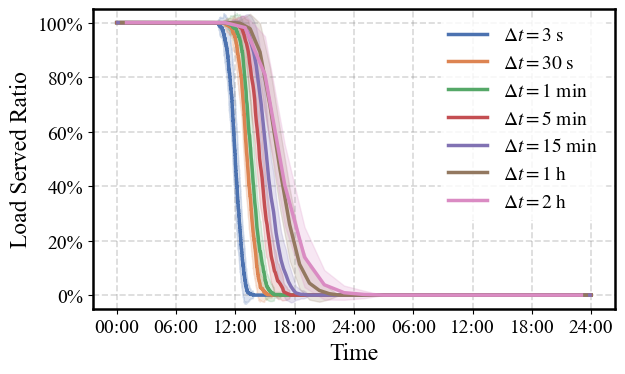

In [11]:
with open("./SolutionFolder/MonteCarlo_Naive_Sample_Ins.pkl", 'rb') as file:
    monte_carlo_naive_sample = pickle.loads(file.read())
    monte_carlo_naive_sample = [monte_carlo_naive_sample[m]["all_load_served"] 
                                for m in range(len(deltaT_list))]
M = len(deltaT_list)
fig = plt.figure(figsize=(6.5, 4))
ax = fig.add_subplot(111)
plt.rc('font', family='Times New Roman', size=15)

colors = sns.color_palette("deep", n_colors=M)
for m in range(0, M-1):
    t = np.arange(0, T, deltaT_list[m]) + deltaT_list[m] / 2
    L_downsampled = downsample(L, deltaT_list[m], 'mean')
    color = colors[m]
    load_served_ratio = monte_carlo_naive_sample[m] / L_downsampled
    df = {'Load Served Ratio': [], 'Time (hours)': []}
    for i in range(N_sim):
        df['Load Served Ratio'].extend(load_served_ratio[i])
        df['Time (hours)'].extend(t)
    sns.lineplot(
        data=df,
        x='Time (hours)',
        y='Load Served Ratio',
        errorbar=('sd', 0.8),
        label=deltaT_name_list[deltaT_list[m]],
        color=colors[m],
        linewidth=2.5
    )
plt.ylim(0 - 0.05, 1.05)
plt.xlabel('Time', fontdict={'family': 'times new roman', 'size': 17, 'style': 'normal'})
plt.ylabel('Load Served Ratio', fontdict={'family': 'times new roman', 'size': 17, 'style': 'normal'})
ax.set_xticks(range(0, T+1, 6))
xticklabels = []
for i in range(0, T+1, 6):
    if i <= 24:
        xticklabels.append(f'{i:02d}:00')
    else:
        xticklabels.append(f'{i-24:02d}:00')
ax.set_xticklabels(xticklabels,font={'family': 'times new roman', 'size': 14, 'style': 'normal'},
                   rotation=0)
ax.set_yticks(np.arange(0, 1.1, 0.2))
yticklabels = [f'{i:d}%' for i in np.arange(0, 101, 20)]
ax.set_yticklabels(yticklabels,font={'family': 'times new roman', 'size': 14, 'style': 'normal'},
                   rotation=0)

plt.legend(loc='best',
           prop={'family': 'times new roman', 'size': 14},
           edgecolor='1.0',
           framealpha=0.8
)

ax.grid(axis='both', color='grey', alpha=0.3, linestyle='--', linewidth=1.2)
ax.spines['bottom'].set_linewidth(1.8)
ax.spines['top'].set_linewidth(1.8)
ax.spines['left'].set_linewidth(1.8)
ax.spines['right'].set_linewidth(1.8)

plt.tight_layout()
plt.show()

## (b)

Method based on fixed component resilience attributes (in [8])

In [12]:
monte_carlo_XULUO_sample = []
for deltaT in deltaT_list:
    print(f">>>deltaT = {deltaT}")
    L_downsampled = downsample(L, deltaT, 'mean')
    w_downsampled = np.zeros((N_sim, round(len(w_example) * BASE_DELTAT / deltaT)))
    for i in range(N_sim):
        w_downsampled[i, :] = downsample(w[i, :], deltaT, 'mean')
    monte_carlo_XULUO_sample.append(MonteCarlo_XULUO_Sample(n, T, deltaT, N_sim, P_gen,
                                                            L_downsampled, w_downsampled, 
                                                            fragility_params={'mu': mu, 'sigma': sigma}))

>>>deltaT = 0.0008333333333333334
Simulation 1/100 (deltaT=0.0008333333333333334)
Simulation 2/100 (deltaT=0.0008333333333333334)
Simulation 3/100 (deltaT=0.0008333333333333334)
Simulation 4/100 (deltaT=0.0008333333333333334)
Simulation 5/100 (deltaT=0.0008333333333333334)
Simulation 6/100 (deltaT=0.0008333333333333334)
Simulation 7/100 (deltaT=0.0008333333333333334)
Simulation 8/100 (deltaT=0.0008333333333333334)
Simulation 9/100 (deltaT=0.0008333333333333334)
Simulation 10/100 (deltaT=0.0008333333333333334)
Simulation 11/100 (deltaT=0.0008333333333333334)
Simulation 12/100 (deltaT=0.0008333333333333334)
Simulation 13/100 (deltaT=0.0008333333333333334)
Simulation 14/100 (deltaT=0.0008333333333333334)
Simulation 15/100 (deltaT=0.0008333333333333334)
Simulation 16/100 (deltaT=0.0008333333333333334)
Simulation 17/100 (deltaT=0.0008333333333333334)
Simulation 18/100 (deltaT=0.0008333333333333334)
Simulation 19/100 (deltaT=0.0008333333333333334)
Simulation 20/100 (deltaT=0.0008333333333333

In [13]:
f_save = open("./SolutionFolder/MonteCarlo_XULUO_Sample_Ins.pkl", 'wb')
pickle.dump(monte_carlo_XULUO_sample, f_save)
f_save.close()

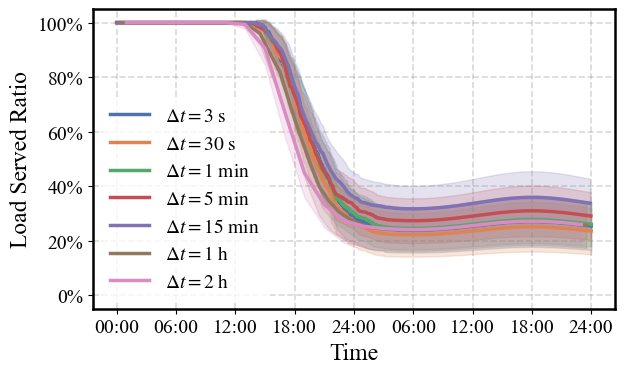

In [14]:
with open("./SolutionFolder/MonteCarlo_XULUO_Sample_Ins.pkl", 'rb') as file:
    monte_carlo_XULUO_sample = pickle.loads(file.read())
    monte_carlo_XULUO_sample = [monte_carlo_XULUO_sample[m]["all_load_served"] 
                                for m in range(len(deltaT_list))]
M = len(deltaT_list)
fig = plt.figure(figsize=(6.5, 4))
ax = fig.add_subplot(111)
plt.rc('font', family='Times New Roman', size=15)

colors = sns.color_palette("deep", n_colors=M)
for m in range(0, M-1):
    t = np.arange(0, T, deltaT_list[m]) + deltaT_list[m] / 2
    L_downsampled = downsample(L, deltaT_list[m], 'mean')
    color = colors[m]
    load_served_ratio = monte_carlo_XULUO_sample[m] / L_downsampled
    df = {'Load Served Ratio': [], 'Time (hours)': []}
    for i in range(N_sim):
        df['Load Served Ratio'].extend(load_served_ratio[i])
        df['Time (hours)'].extend(t)
        df['Load Served Ratio'].extend(load_served_ratio[i])
        df['Time (hours)'].extend(t)
    sns.lineplot(
        data=df,
        x='Time (hours)',
        y='Load Served Ratio',
        errorbar=('sd', 0.5),
        label=deltaT_name_list[deltaT_list[m]],
        color=colors[m],
        linewidth=2.5,
    )

plt.ylim(0 - 0.05, 1.05)
plt.xlabel('Time', fontdict={'family': 'times new roman', 'size': 17, 'style': 'normal'})
plt.ylabel('Load Served Ratio', fontdict={'family': 'times new roman', 'size': 17, 'style': 'normal'})
ax.set_xticks(range(0, T+1, 6))
xticklabels = []
for i in range(0, T+1, 6):
    if i <= 24:
        xticklabels.append(f'{i:02d}:00')
    else:
        xticklabels.append(f'{i-24:02d}:00')
ax.set_xticklabels(xticklabels,font={'family': 'times new roman', 'size': 14, 'style': 'normal'},
                   rotation=0)
ax.set_yticks(np.arange(0, 1.1, 0.2))
yticklabels = [f'{i:d}%' for i in np.arange(0, 101, 20)]
ax.set_yticklabels(yticklabels,font={'family': 'times new roman', 'size': 14, 'style': 'normal'},
                   rotation=0)

plt.legend(loc='best',
           prop={'family': 'times new roman', 'size': 14},
           edgecolor='1.0',
           framealpha=0.8
)

ax.grid(axis='both', color='grey', alpha=0.3, linestyle='--', linewidth=1.2)
ax.spines['bottom'].set_linewidth(1.8)
ax.spines['top'].set_linewidth(1.8)
ax.spines['left'].set_linewidth(1.8)
ax.spines['right'].set_linewidth(1.8)

plt.tight_layout()
plt.show()

## (c)

Method based on conditional probability correction (proposed)

In [15]:
monte_carlo_past_info_sample = []
for deltaT in deltaT_list:
    print(f">>>deltaT = {deltaT}")
    L_downsampled = downsample(L, deltaT, 'mean')
    w_downsampled = np.zeros((N_sim, round(len(w_example) * BASE_DELTAT / deltaT)))
    for i in range(N_sim):
        w_downsampled[i, :] = downsample(w[i, :], deltaT, 'mean')
    monte_carlo_past_info_sample.append(MonteCarlo_Past_Info_Sample(
                                        n, T, deltaT, N_sim, P_gen,
                                        L_downsampled, w_downsampled, 
                                        fragility_params={'mu': mu, 'sigma': sigma},
                                        prob_method={'name': 'abs_resilience'}
                                                     )
                                                     )
    

>>>deltaT = 0.0008333333333333334
Simulation 1/100 (deltaT=0.0008333333333333334)
Simulation 2/100 (deltaT=0.0008333333333333334)
Simulation 3/100 (deltaT=0.0008333333333333334)
Simulation 4/100 (deltaT=0.0008333333333333334)
Simulation 5/100 (deltaT=0.0008333333333333334)
Simulation 6/100 (deltaT=0.0008333333333333334)
Simulation 7/100 (deltaT=0.0008333333333333334)
Simulation 8/100 (deltaT=0.0008333333333333334)
Simulation 9/100 (deltaT=0.0008333333333333334)
Simulation 10/100 (deltaT=0.0008333333333333334)
Simulation 11/100 (deltaT=0.0008333333333333334)
Simulation 12/100 (deltaT=0.0008333333333333334)
Simulation 13/100 (deltaT=0.0008333333333333334)
Simulation 14/100 (deltaT=0.0008333333333333334)
Simulation 15/100 (deltaT=0.0008333333333333334)
Simulation 16/100 (deltaT=0.0008333333333333334)
Simulation 17/100 (deltaT=0.0008333333333333334)
Simulation 18/100 (deltaT=0.0008333333333333334)
Simulation 19/100 (deltaT=0.0008333333333333334)
Simulation 20/100 (deltaT=0.0008333333333333

In [16]:
f_save = open("./SolutionFolder/MonteCarlo_Past_Info_Sample_Ins.pkl", 'wb')
pickle.dump(monte_carlo_past_info_sample, f_save)
f_save.close()

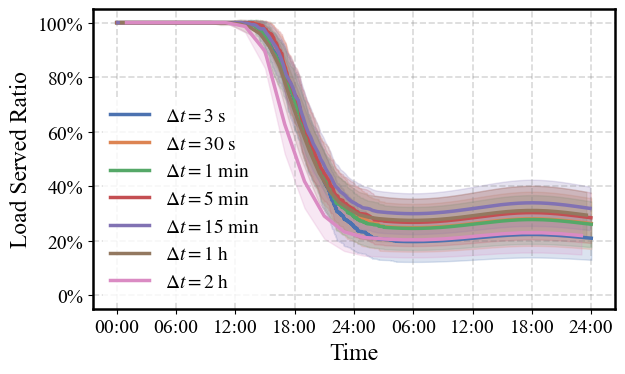

In [17]:
with open("./SolutionFolder/MonteCarlo_Past_Info_Sample_Ins.pkl", 'rb') as file:
    monte_carlo_past_info_sample = pickle.loads(file.read())
    monte_carlo_past_info_sample = [monte_carlo_past_info_sample[m]["all_load_served"] 
                                    for m in range(len(deltaT_list))]
M = len(deltaT_list)
fig = plt.figure(figsize=(6.5, 4))
ax = fig.add_subplot(111)
plt.rc('font', family='Times New Roman', size=15)

colors = sns.color_palette("deep", n_colors=M)
for m in range(0, M-1):
    t = np.arange(0, T, deltaT_list[m]) + deltaT_list[m] / 2
    L_downsampled = downsample(L, deltaT_list[m], 'mean')
    color = colors[m]
    load_served_ratio = monte_carlo_past_info_sample[m] / L_downsampled
    df = {'Load Served Ratio': [], 'Time (hours)': []}
    for i in range(N_sim):
        df['Load Served Ratio'].extend(load_served_ratio[i])
        df['Time (hours)'].extend(t)
        df['Load Served Ratio'].extend(load_served_ratio[i])
        df['Time (hours)'].extend(t)
    sns.lineplot(
        data=df,
        x='Time (hours)',
        y='Load Served Ratio',
        errorbar=('sd', 0.5),
        label=deltaT_name_list[deltaT_list[m]],
        color=colors[m],
        linewidth=2.5,
    )

plt.ylim(0 - 0.05, 1.05)
plt.xlabel('Time', fontdict={'family': 'times new roman', 'size': 17, 'style': 'normal'})
plt.ylabel('Load Served Ratio', fontdict={'family': 'times new roman', 'size': 17, 'style': 'normal'})
ax.set_xticks(range(0, T+1, 6))
xticklabels = []
for i in range(0, T+1, 6):
    if i <= 24:
        xticklabels.append(f'{i:02d}:00')
    else:
        xticklabels.append(f'{i-24:02d}:00')
ax.set_xticklabels(xticklabels,font={'family': 'times new roman', 'size': 14, 'style': 'normal'},
                   rotation=0)
ax.set_yticks(np.arange(0, 1.1, 0.2))
yticklabels = [f'{i:d}%' for i in np.arange(0, 101, 20)]
ax.set_yticklabels(yticklabels,font={'family': 'times new roman', 'size': 14, 'style': 'normal'},
                   rotation=0)
plt.legend(loc='best',
           prop={'family': 'times new roman', 'size': 14},
           edgecolor='1.0',
           framealpha=0.8
)
ax.grid(axis='both', color='grey', alpha=0.3, linestyle='--', linewidth=1.2)
ax.spines['bottom'].set_linewidth(1.8)
ax.spines['top'].set_linewidth(1.8)
ax.spines['left'].set_linewidth(1.8)
ax.spines['right'].set_linewidth(1.8)

plt.tight_layout()
plt.show()

## (d)

Benchmark

In [18]:
monte_carlo_Fatigue_Accumulation_sample = []
for deltaT in deltaT_list:
    deltaT = BASE_DELTAT # A Benchmark is based on the underlying physical mechanisms as the standard answer, using the finest studied resolution.
    print(f">>>deltaT = {deltaT}")
    L_downsampled = downsample(L, deltaT, 'mean')
    w_downsampled = np.zeros((N_sim, round(len(w_example) * BASE_DELTAT / deltaT)))
    for i in range(N_sim):
        w_downsampled[i, :] = downsample(w[i, :], deltaT, 'mean')   
    monte_carlo_Fatigue_Accumulation_sample.append(MonteCarlo_Fatigue_Accumulation_Sample(
                                        n, T, deltaT, N_sim, P_gen,
                                        L_downsampled, w_downsampled, 
                                        fragility_params={'a': a, 'b': b, 'v0': v0, 'vmax': vmax, 'Dres': Dres}))
    break

>>>deltaT = 0.0008333333333333334
Simulation 1/100 (deltaT=0.0008333333333333334)
Simulation 2/100 (deltaT=0.0008333333333333334)
Simulation 3/100 (deltaT=0.0008333333333333334)
Simulation 4/100 (deltaT=0.0008333333333333334)
Simulation 5/100 (deltaT=0.0008333333333333334)
Simulation 6/100 (deltaT=0.0008333333333333334)
Simulation 7/100 (deltaT=0.0008333333333333334)
Simulation 8/100 (deltaT=0.0008333333333333334)
Simulation 9/100 (deltaT=0.0008333333333333334)
Simulation 10/100 (deltaT=0.0008333333333333334)
Simulation 11/100 (deltaT=0.0008333333333333334)
Simulation 12/100 (deltaT=0.0008333333333333334)
Simulation 13/100 (deltaT=0.0008333333333333334)
Simulation 14/100 (deltaT=0.0008333333333333334)
Simulation 15/100 (deltaT=0.0008333333333333334)
Simulation 16/100 (deltaT=0.0008333333333333334)
Simulation 17/100 (deltaT=0.0008333333333333334)
Simulation 18/100 (deltaT=0.0008333333333333334)
Simulation 19/100 (deltaT=0.0008333333333333334)
Simulation 20/100 (deltaT=0.0008333333333333

In [19]:
f_save = open("./SolutionFolder/MonteCarlo_Fatigue_Accumulation_Sample_Ins.pkl", 'wb')
pickle.dump(monte_carlo_Fatigue_Accumulation_sample, f_save)
f_save.close()

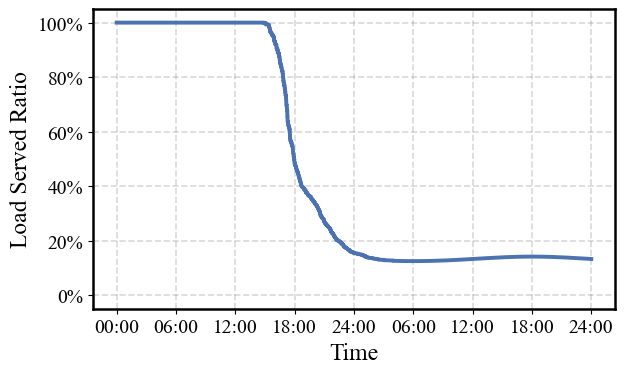

In [20]:
with open("./SolutionFolder/MonteCarlo_Fatigue_Accumulation_Sample_Ins.pkl", 'rb') as file:
    monte_carlo_Fatigue_Accumulation_sample = pickle.loads(file.read())
    monte_carlo_Fatigue_Accumulation_sample = \
        [monte_carlo_Fatigue_Accumulation_sample[m]["all_load_served"] 
         for m in range(len(monte_carlo_Fatigue_Accumulation_sample))]
M = len(deltaT_list)
fig = plt.figure(figsize=(6.5, 4))
ax = fig.add_subplot(111)
plt.rc('font', family='Times New Roman', size=15)

colors = sns.color_palette("deep", n_colors=M)
for m in range(0, M):
    deltaT_list_m = BASE_DELTAT
    t = np.arange(0, T, deltaT_list_m) + deltaT_list_m / 2
    L_downsampled = downsample(L, deltaT_list_m, method='mean')
    color = colors[m]
    load_served_ratio = monte_carlo_Fatigue_Accumulation_sample[m] / L_downsampled
    df = {'Load Served Ratio': [], 'Time (hours)': []}
    for i in range(0, N_sim):
        df['Load Served Ratio'].extend(load_served_ratio[i])
        df['Time (hours)'].extend(t)
        df['Load Served Ratio'].extend(load_served_ratio[i])
        df['Time (hours)'].extend(t)
    sns.lineplot(
        data=df,
        x='Time (hours)',
        y='Load Served Ratio',
        errorbar=None,
        color=colors[m],
        linewidth=2.8,
    )
    break
plt.ylim(0 - 0.05, 1.05)
plt.xlabel('Time', fontdict={'family': 'times new roman', 'size': 17, 'style': 'normal'})
plt.ylabel('Load Served Ratio', fontdict={'family': 'times new roman', 'size': 17, 'style': 'normal'})
ax.set_xticks(range(0, T+1, 6))
xticklabels = []
for i in range(0, T+1, 6):
    if i <= 24:
        xticklabels.append(f'{i:02d}:00')
    else:
        xticklabels.append(f'{i-24:02d}:00')
ax.set_xticklabels(xticklabels,font={'family': 'times new roman', 'size': 14, 'style': 'normal'},
                   rotation=0)
ax.set_yticks(np.arange(0, 1.01, 0.2))
yticklabels = [f'{i:d}%' for i in np.arange(0, 101, 20)]
ax.set_yticklabels(yticklabels,font={'family': 'times new roman', 'size': 14, 'style': 'normal'},
                   rotation=0)

ax.grid(axis='both', color='grey', alpha=0.3, linestyle='--', linewidth=1.2)
ax.spines['bottom'].set_linewidth(1.8)
ax.spines['top'].set_linewidth(1.8)
ax.spines['left'].set_linewidth(1.8)
ax.spines['right'].set_linewidth(1.8)

plt.tight_layout()
plt.show()